In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle as pkl
import numpy as np
import pandas as pd 


with open('/content/drive/MyDrive/Dataset_with_memory /15min/X_train_15min.pickle', 'rb') as f:
    X_train = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /15min/Y_train_15min.pickle', 'rb') as f:
    Y_train = pkl.load(f)


with open('/content/drive/MyDrive/Dataset_with_memory /15min/Y_val_15min.pickle', 'rb') as f:
    Y_val = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /15min/X_val_15min.pickle', 'rb') as f:
     X_val = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /15min/Y_test_15min.pickle', 'rb') as f:
    Y_test = pkl.load(f)

with open('/content/drive/MyDrive/Dataset_with_memory /15min/X_test_15min.pickle', 'rb') as f:
     X_test = pkl.load(f)


Y_train = Y_train.reshape((-1,1))
Y_val = Y_val.reshape((-1,1))
Y_test = Y_test.reshape((-1,1))

X_train.shape , Y_train.shape , X_val.shape , Y_val.shape , X_test.shape , Y_test.shape

((225480, 120, 5),
 (225480, 1),
 (45000, 120, 5),
 (45000, 1),
 (135240, 120, 5),
 (135240, 1))

In [3]:
from sklearn.utils.class_weight import compute_class_weight



class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique ( np.reshape( Y_train , (np.shape(Y_train)[0]))),
                                        y = np.reshape(Y_train ,(np.shape(Y_train)[0]))                                                 
                                    )
class_weights = dict(zip(np.unique(np.reshape(Y_train ,(np.shape(Y_train)[0]))), class_weights))
class_weights


{0: 1.0214917367352856, 1: 0.9793939815136563}

In [4]:
import os

filepath = "/content/drive/MyDrive/parameter_tuning_GRU_15min.csv"

# check if the file exists, create it if not
if not os.path.isfile(filepath):
    columns_name = ['GRU_blocks', 'learning_rate', 'regularizer', 'droput', 'optimizer', 'batch size' , 'weight_decay',
                    'train_loss' , 'val_loss' , 'train_accuracy' , 'val_accuracy', 'test_loss' , 'test_accuracy']
    df = pd.DataFrame(columns=columns_name)  # create an empty dataframe
    df.to_csv(filepath, index=False)  # save as a CSV file with no index


In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow import keras
import numpy as np 

#reproducibility 
np.random.seed(0)
tf.random.set_seed(0)

#defining hyperparameters

weight_decay = 1e-7
GRU_blocks= 20
regularizer = 0
lr = 0.001
dropout  = 0.5
batchsize = 128
optimizer_func = 'Adam'
#threshold = 0.5

# Define the model
def create_model(GRU_blocks, regularizer, dropout):
    model = Sequential()
    #model.add(BatchNormalization(input_shape=(120, 5)))
    model.add(GRU(GRU_blocks, input_shape=(120, 5) , return_sequences=False, activation='tanh', bias_regularizer=regularizers.l1(regularizer),  kernel_regularizer=regularizers.l1(regularizer)))
   

    model.add(Dropout(dropout))

    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    return model 


model = create_model(GRU_blocks, regularizer, dropout)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 20)                1620      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                1050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,721
Trainable params: 2,721
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=lr,weight_decay=weight_decay) if optimizer_func == 'Adam' else keras.optimizers.SGD(learning_rate=lr ,weight_decay=weight_decay)

model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['binary_accuracy' ])


checkpoint_path = '/content/drive/MyDrive/my_best_model_GRU_15min.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_binary_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')


earlystopping = EarlyStopping(monitor='val_binary_accuracy', patience=10, restore_best_weights=True)

callback = [earlystopping, checkpoint]
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_val , Y_val) , verbose=1,  batch_size=batchsize, epochs=150,callbacks = callback, class_weight=class_weights)

loss, accuracy = model.evaluate(X_test, Y_test, batch_size=batchsize)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

filepath = "/content/drive/MyDrive/parameter_tuning_GRU_15min.csv"
parameters_to_save = pd.read_csv(filepath)

parameters_to_save = parameters_to_save.append({'GRU_blocks' : GRU_blocks, 'learning_rate': lr, 'regularizer': regularizer, 'droput': dropout, 
                                                'optimizer': optimizer_func, 'batch size': batchsize, 'weight_decay': weight_decay,
                                                'train_loss' : history.history['loss'][-1] ,'val_loss' : history.history['val_loss'][-1] , 
                                                'train_accuracy' : history.history['binary_accuracy'][-1] , 'val_accuracy' : history.history['val_binary_accuracy'][-1],
                                                'test_loss' : f"{loss:.4f}" , 'test_accuracy' : f"{accuracy*100:.2f}%" } , ignore_index = True ) 

parameters_to_save.to_csv(filepath, index=False)


Epoch 1/150
1757/1762 [============================>.] - ETA: 0s - loss: 0.3289 - binary_accuracy: 0.8642
Epoch 1: val_binary_accuracy improved from -inf to 0.85858, saving model to /content/drive/MyDrive/my_best_model_GRU_15min.hdf5
1762/1762 [==============================] - 22s 10ms/step - loss: 0.3289 - binary_accuracy: 0.8642 - val_loss: 0.3256 - val_binary_accuracy: 0.8586
Epoch 2/150
1762/1762 [==============================] - ETA: 0s - loss: 0.2941 - binary_accuracy: 0.8773
Epoch 2: val_binary_accuracy improved from 0.85858 to 0.86449, saving model to /content/drive/MyDrive/my_best_model_GRU_15min.hdf5
1762/1762 [==============================] - 19s 11ms/step - loss: 0.2941 - binary_accuracy: 0.8773 - val_loss: 0.3176 - val_binary_accuracy: 0.8645
Epoch 3/150
1756/1762 [============================>.] - ETA: 0s - loss: 0.2903 - binary_accuracy: 0.8782
Epoch 3: val_binary_accuracy did not improve from 0.86449
1762/1762 [==============================] - 16s 9ms/step - loss: 0

<ipython-input-8-c97b076109cc>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters_to_save = parameters_to_save.append({'GRU_blocks' : GRU_blocks, 'learning_rate': lr, 'regularizer': regularizer, 'droput': dropout,


In [9]:
Y_pred_prob = model.predict(X_test)
Y_pred_prob.shape

4227/4227 [==============================] - 14s 3ms/step


(135240, 1)

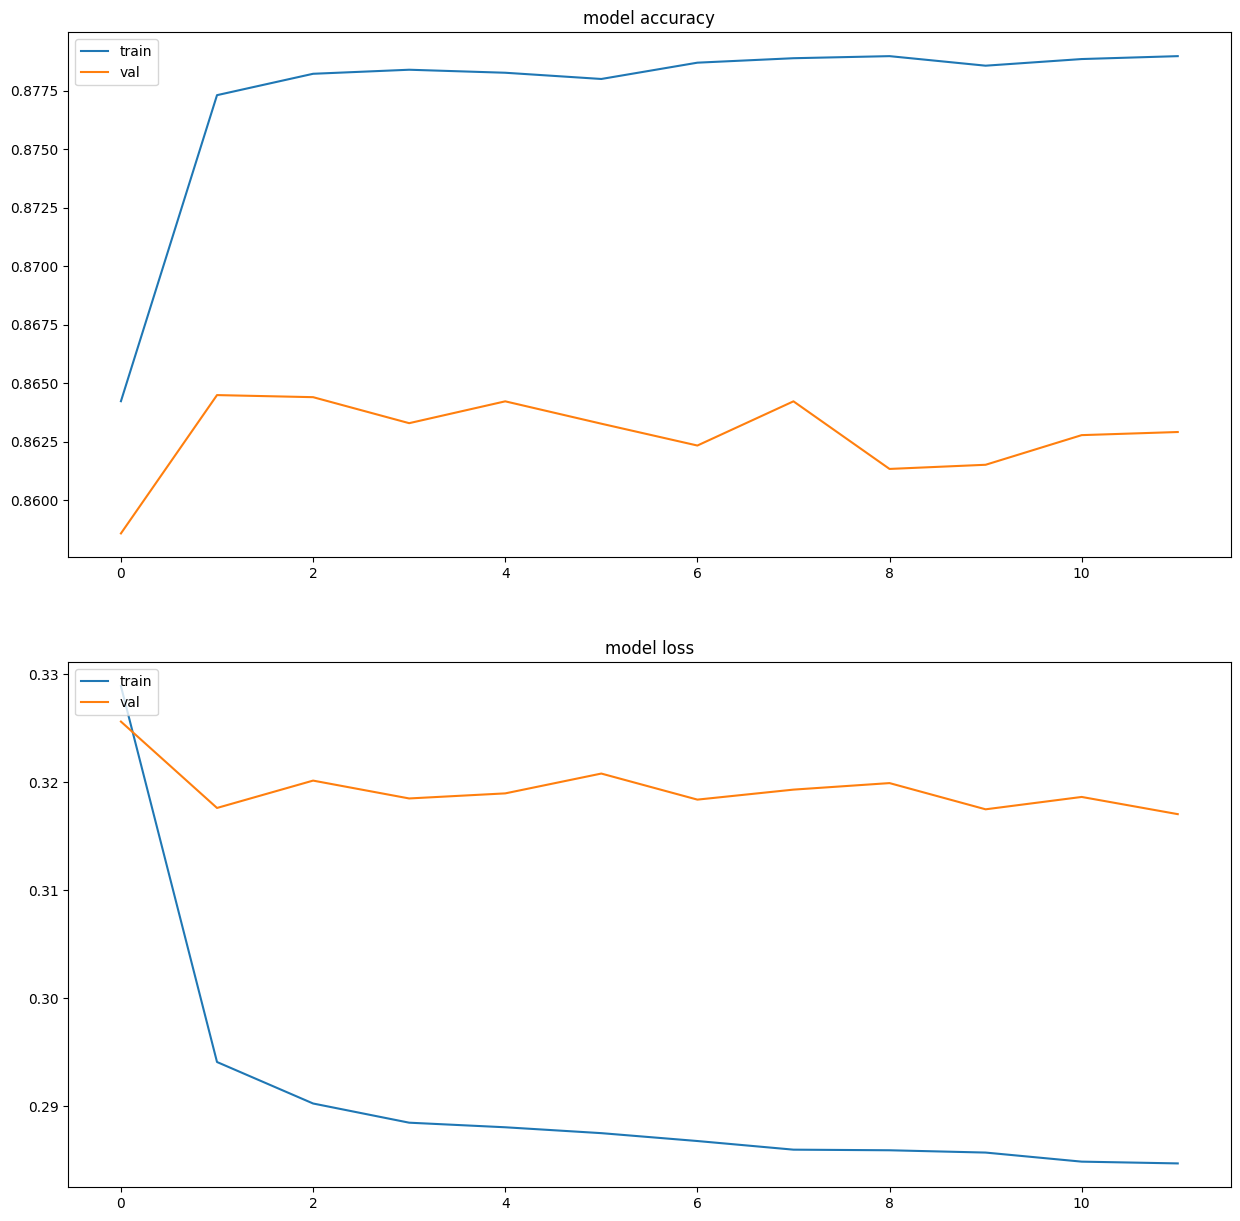

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1, figsize = (15,15))
axs = axs.flatten()
axs[0].plot(history.history['binary_accuracy'])
axs[0].plot(history.history['val_binary_accuracy'])
axs[0].set_title('model accuracy')

axs[0].legend(['train', 'val'], loc='upper left')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

axs[1].legend(['train', 'val'], loc='upper left')
